In [1]:
import warnings
import xarray
import intake
import cmocean as cm
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from xmovie import Movie
import matplotlib.path as mpath
import xarray as xr
import cartopy.feature as cft
import numpy as np
import cosima_cookbook as cc
import pandas as pd

pd.set_option('display.max_columns', None)

warnings.filterwarnings("ignore") # Suppress warnings for these docs

In [2]:
from dask.distributed import Client

client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/37351/status,
Dashboard: /proxy/37351/status,Workers: 7
Total threads: 7,Total memory: 256.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44467,Workers: 7
Dashboard: /proxy/37351/status,Total threads: 7
Started: Just now,Total memory: 256.00 GiB
Comm: tcp://127.0.0.1:45325,Total threads: 1
Dashboard: /proxy/39393/status,Memory: 36.57 GiB
Nanny: tcp://127.0.0.1:39827,


In [3]:
import cosima_cookbook as cc
db = 'local_cc_scratch_Ryan_data.db'
session = cc.database.create_session(db)

In [4]:
# tau_y = cc.querying.getvar(expt='025deg_era5_iaf_1958cycle1', variable='tau_y', 
#                           session=session, frequency='1 monthly',
#                           attrs={'cell_methods': 'time: mean'},
#                           chunks={'time':-1,'xu_ocean':'300MB','yu_ocean':'300MB'})
# tau_y

tau_y = cc.querying.getvar(expt='025deg_jra55_iaf_cycle6_online_mlt', variable='tau_y', 
                           session=session, frequency='1 monthly',
                           attrs={'cell_methods': 'time: mean'},
                           chunks={'time':-1,'xu_ocean':'300MB','yu_ocean':'300MB'}).\
                            sel(time = slice('1982','2023'))

tau_y

<xarray.DataArray 'tau_y' (time: 504, yu_ocean: 1080, xu_ocean: 1440)> Size: 3GB
dask.array<getitem, shape=(504, 1080, 1440), dtype=float32, chunksize=(12, 1080, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 4kB 1982-01-14T12:00:00 ... 2023-12-14T12...
  * xu_ocean  (xu_ocean) float64 12kB -279.8 -279.5 -279.2 ... 79.5 79.75 80.0
  * yu_ocean  (yu_ocean) float64 9kB -81.02 -80.92 -80.81 ... 89.79 89.89 90.0
Attributes:
    long_name:      j-directed wind stress forcing v-velocity
    units:          N/m^2
    valid_range:    [-10.  10.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  surface_downward_y_stress
    ncfiles:        ['/g/data/e14/rmh561/access-om2/archive/025deg_jra55_iaf_...
    contact:        Ryan Holmes
    email:          ryan.holmes@unsw.edu.au
    created:        2020-11-03
    description:    0.25 degree ACCESS-OM2 global model configuration under i...

In [5]:
import xarray as xr
tau_y_subset = tau_y.sel(time=slice("1982-01-01", "2011-12-31"))

clim_y = tau_y_subset.groupby("time.month").mean(dim="time", keep_attrs=True)

In [6]:
# tau_x = cc.querying.getvar(expt='025deg_era5_iaf_1958cycle1', variable='tau_x', 
#                           session=session, frequency='1 monthly',
#                           attrs={'cell_methods': 'time: mean'},
#                           chunks={'time':-1,'xu_ocean':'300MB','yu_ocean':'300MB'})
# tau_x

tau_x = cc.querying.getvar(
    expt='025deg_jra55_iaf_cycle6_online_mlt',
    variable='tau_x',
    session=session,
    frequency='1 monthly',
    attrs={'cell_methods': 'time: mean'},
    chunks={'time': -1, 'xu_ocean': '300MB', 'yu_ocean': '300MB'}
).sel(time = slice('1982','2023'))

tau_x

<xarray.DataArray 'tau_x' (time: 504, yu_ocean: 1080, xu_ocean: 1440)> Size: 3GB
dask.array<getitem, shape=(504, 1080, 1440), dtype=float32, chunksize=(12, 1080, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 4kB 1982-01-14T12:00:00 ... 2023-12-14T12...
  * xu_ocean  (xu_ocean) float64 12kB -279.8 -279.5 -279.2 ... 79.5 79.75 80.0
  * yu_ocean  (yu_ocean) float64 9kB -81.02 -80.92 -80.81 ... 89.79 89.89 90.0
Attributes:
    long_name:      i-directed wind stress forcing u-velocity
    units:          N/m^2
    valid_range:    [-10.  10.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  surface_downward_x_stress
    ncfiles:        ['/g/data/e14/rmh561/access-om2/archive/025deg_jra55_iaf_...
    contact:        Ryan Holmes
    email:          ryan.holmes@unsw.edu.au
    created:        2020-11-03
    description:    0.25 degree ACCESS-OM2 global model configuration under i...

In [7]:
import xarray as xr
tau_x_subset = tau_x.sel(time=slice("1982-01-01", "2011-12-31"))

clim_x = tau_x_subset.groupby("time.month").mean(dim="time", keep_attrs=True)

In [8]:
mag_clim = np.sqrt(clim_x**2 + clim_y**2)
mag_clim

<xarray.DataArray (month: 12, yu_ocean: 1080, xu_ocean: 1440)> Size: 75MB
dask.array<sqrt, shape=(12, 1080, 1440), dtype=float32, chunksize=(12, 1080, 1440), chunktype=numpy.ndarray>
Coordinates:
  * xu_ocean  (xu_ocean) float64 12kB -279.8 -279.5 -279.2 ... 79.5 79.75 80.0
  * yu_ocean  (yu_ocean) float64 9kB -81.02 -80.92 -80.81 ... 89.79 89.89 90.0
  * month     (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

In [9]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cft
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import string

# Set global font
plt.rcParams['font.family'] = 'DejaVu Sans'

months_to_plot = pd.date_range("2021-11-01", "2022-02-01", freq="MS")
n_panels = len(months_to_plot)

# Define the grid layout (2x2 for 4 months)
ncols = 2
nrows = (n_panels + ncols - 1) // ncols

fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols,
    figsize=(14, 10),
    subplot_kw={'projection': ccrs.Mercator(central_longitude=180)}
)
axes = axes.flatten()

# Shared plotting parameters
levels = np.linspace(-0.15, 0.15, 61)
s = 15  # Subsampling rate

# Loop each month
for i, t in enumerate(months_to_plot):
    ax = axes[i]

    # Select correct month
    tau_x_month = tau_x.sel(time=t, method="nearest")
    tau_y_month = tau_y.sel(time=t, method="nearest")
    mag_year = np.sqrt(tau_x_month**2 + tau_y_month**2)
    mag_clim_month = mag_clim.sel(month=t.month)
    mag_anom = mag_year - mag_clim_month

    # Map
    ax.set_extent([-200, -130, -78, -65], crs=ccrs.PlateCarree())
    ax.add_feature(cft.LAND, facecolor='lightgray', zorder=2)
    ax.coastlines(resolution='50m', zorder=3)

    # Gridlines that show what I want
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1,
                      color='gray', alpha=0.5, linestyle='--', zorder=1)
    gl.xlocator = mticker.FixedLocator([160, 180, -160, -140])
    gl.ylocator = mticker.FixedLocator([-75, -70, -65])
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = (i % ncols == 0)
    gl.bottom_labels = (i >= n_panels - ncols)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12}
    gl.ylabel_style = {'size': 12}

    # Plot data
    contour = ax.contourf(mag_anom.xu_ocean, mag_anom.yu_ocean, mag_anom,
                          levels=levels, cmap='RdBu_r', transform=ccrs.PlateCarree(),
                          extend='both')

    tau_x_sub = tau_x_month.values[::s, ::s]
    tau_y_sub = tau_y_month.values[::s, ::s]
    # mag_sub = np.sqrt(tau_x_sub**2 + tau_y_sub**2) 

    # Make sure you have quivers
    q = ax.quiver(tau_x_month.xu_ocean[::s], tau_x_month.yu_ocean[::s],
                  tau_x_sub, tau_y_sub, scale=2.0, color='black',
                  transform=ccrs.PlateCarree(),
                  width=0.003, alpha=0.9, zorder=4)

    # Quiver key (reference vector) for each panel
    ax.quiverkey(q, X=0.85, Y=1.05, U=0.2, label='0.2 N/m²', labelpos='E',
                 coordinates='axes', fontproperties={'size': 10})

    panel_label = string.ascii_lowercase[i]
    title = f"{panel_label}. {t.strftime('%B %Y')}"
    ax.set_title(title, loc='left', fontsize=14, fontweight='bold')

# Colourbars
cbar_anom_ax = fig.add_axes([0.15, 0.06, 0.7, 0.025])
cbar_anom = fig.colorbar(contour, cax=cbar_anom_ax, orientation='horizontal', extend='both')
cbar_anom.set_label("Wind Stress Anomaly (N/m²)", fontsize=12)
cbar_anom.ax.tick_params(labelsize=12)

plt.suptitle("Ross Sea Wind Stress Anomaly & Vectors", fontsize=18, fontweight='bold', y=0.98)


plt.subplots_adjust(
    top=0.92,
    bottom=0.12,  # REDUCED: Closes gap from removed colorbar.
    left=0.08,
    right=0.95,
    hspace=0.15,
    wspace=0.05
)

output_path = "/g/data/e14/ts7341/wind/ross_sea_wind_stress_multi_panel_fixed_black_vectors.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"Saved figure: {output_path}")
plt.show()

Saved figure: /g/data/e14/ts7341/wind/ross_sea_wind_stress_multi_panel_fixed_black_vectors.png


In [10]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cft
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import string
# import matplotlib.colors as mcolors # No longer needed for quiver

# --- SCRIPT ASSUMPTIONS ---
# This script assumes you have already loaded your data into xarray DataArrays
# named `tau_x`, `tau_y`, and `mag_clim`.
# -----------------------------

# Set global font
plt.rcParams['font.family'] = 'DejaVu Sans'

# --- SETUP FOR MULTI-PANEL PLOT ---
# Define the months to plot, same as the original script
months_to_plot = pd.date_range("2016-11-01", "2017-02-01", freq="MS")
n_panels = len(months_to_plot)

# Define the grid layout (2x2 for 4 months)
ncols = 2
nrows = (n_panels + ncols - 1) // ncols

# Create the figure and grid of subplots
fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols,
    figsize=(14, 10),
    subplot_kw={'projection': ccrs.Mercator(central_longitude=-20)}
)
axes = axes.flatten()

# Shared plotting parameters
levels = np.linspace(-0.15, 0.15, 61)
s = 15  # Subsampling rate

for i, t in enumerate(months_to_plot):
    ax = axes[i]

    tau_x_month = tau_x.sel(time=t, method="nearest")
    tau_y_month = tau_y.sel(time=t, method="nearest")
    mag_year = np.sqrt(tau_x_month**2 + tau_y_month**2)
    mag_clim_month = mag_clim.sel(month=t.month)
    mag_anom = mag_year - mag_clim_month

    # Weddell Sea
    ax.set_extent([-70, 30, -72, -55], crs=ccrs.PlateCarree())
    ax.add_feature(cft.LAND, facecolor='lightgray', zorder=2)
    ax.coastlines(resolution='50m', zorder=3)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1,
                      color='gray', alpha=0.5, linestyle='--', zorder=1)

    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = (i % ncols == 0) # Only label the left column
    gl.bottom_labels = (i >= n_panels - ncols) # Only label the bottom row
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12}
    gl.ylabel_style = {'size': 12}

    # Plot
    mesh_plot = ax.pcolormesh(mag_anom.xu_ocean, mag_anom.yu_ocean, mag_anom,
                              cmap='RdBu_r', transform=ccrs.PlateCarree(),
                              vmin=levels.min(), vmax=levels.max())

    # Subsample vectors
    tau_x_sub = tau_x_month.values[::s, ::s]
    tau_y_sub = tau_y_month.values[::s, ::s]
    
    q = ax.quiver(tau_x_month.xu_ocean[::s], tau_x_month.yu_ocean[::s],
                  tau_x_sub, tau_y_sub, scale=2.0, color='black',
                  transform=ccrs.PlateCarree(),
                  width=0.003, alpha=0.9, zorder=4)

    # Quiver key (reference vector) for each panel
    ax.quiverkey(q, X=0.85, Y=1.05, U=0.2, label='0.2 N/m²', labelpos='E',
                 coordinates='axes', fontproperties={'size': 10})

    panel_label = string.ascii_lowercase[i]
    title = f"{panel_label}. {t.strftime('%B %Y')}"
    ax.set_title(title, loc='left', fontsize=14, fontweight='bold')

cbar_anom_ax = fig.add_axes([0.15, 0.06, 0.7, 0.025])
cbar_anom = fig.colorbar(mesh_plot, cax=cbar_anom_ax, orientation='horizontal', extend='both')
cbar_anom.set_label("Wind Stress Anomaly (N/m²)", fontsize=12)
cbar_anom.ax.tick_params(labelsize=12)

# --- MAIN FIGURE TITLE ---
plt.suptitle("Weddell Sea Wind Stress Anomaly & Vectors", fontsize=18, fontweight='bold', y=0.98)

# --- MODIFICATION 3: ADJUSTED LAYOUT ---
# `bottom` is reduced to tighten the space left by the removed colorbar.
plt.subplots_adjust(
    top=0.92,
    bottom=0.12, # REDUCED: Closes gap from removed colorbar.
    left=0.08,
    right=0.95,
    hspace=0.15,
    wspace=0.05
)

# --- SAVE FIGURE ---
# Save the entire multi-panel figure as a single file
output_path = "/g/data/e14/ts7341/wind/ws/weddell_sea_wind_stress_multi_panel_black_vectors.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"Saved figure: {output_path}")
plt.show()

Saved figure: /g/data/e14/ts7341/wind/ws/weddell_sea_wind_stress_multi_panel_black_vectors.png


In [63]:
# import xarray as xr
# import numpy as np

# R_EARTH = 6.371e6  # Earth radius in meters

# def deg2m(lat):
#     lat_rad = np.deg2rad(lat)
#     dx = (np.pi / 180) * R_EARTH * np.cos(lat_rad)  # m per deg lon
#     dy = (np.pi / 180) * R_EARTH                    # m per deg lat
#     return dx, dy

# def calculate_monthly_climatology(data, start_year=1982, end_year=2011):
#     """Returns monthly mean climatology."""
#     data_clim_period = data.sel(
#         time=(data['time'].dt.year >= start_year) & 
#              (data['time'].dt.year <= end_year)
#     )
#     monthly_clim = data_clim_period.groupby('time.month').mean('time')
#     return monthly_clim

# def compute_anomalous_curl_monthly(tau_x, tau_y, tau_x_clim, tau_y_clim):
#     """Compute curl of monthly wind stress anomalies."""
#     # Compute anomalies
#     tau_x_anom = tau_x.groupby('time.month') - tau_x_clim
#     tau_y_anom = tau_y.groupby('time.month') - tau_y_clim

#     lat = tau_x.yu_ocean
#     lon = tau_x.xu_ocean

#     # Convert to meters per degree
#     dx_vals, dy_vals = deg2m(lat)

#     # Convert to xarray DataArrays
#     dx = xr.DataArray(dx_vals, coords={'yu_ocean': lat}, dims=['yu_ocean'])
#     dy = xr.DataArray(dy_vals, coords={'yu_ocean': lat}, dims=['yu_ocean'])

#     # Broadcast to 2D (lat × lon)
#     DX, _ = xr.broadcast(dx, tau_x.isel(time=0))
#     DY, _ = xr.broadcast(dy, tau_x.isel(time=0))

#     # Compute spatial derivatives
#     d_tau_y_dx = tau_y_anom.differentiate('xu_ocean') / DX
#     d_tau_x_dy = tau_x_anom.differentiate('yu_ocean') / DY

#     # Final curl anomaly
#     curl_anom = d_tau_y_dx - d_tau_x_dy

#     return curl_anom



In [7]:
# Step 1: Monthly climatology
tau_x_clim = calculate_monthly_climatology(tau_x)
tau_y_clim = calculate_monthly_climatology(tau_y)
%matplotlib inline

# Step 2–3: Anomalous curl
curl_anom = compute_anomalous_curl_monthly(tau_x, tau_y, tau_x_clim, tau_y_clim)
curl_anom = curl_anom.sel(yu_ocean = slice(-90,-55))
curl_anom

<xarray.DataArray (time: 504, yu_ocean: 233, xu_ocean: 1440)> Size: 1GB
dask.array<getitem, shape=(504, 233, 1440), dtype=float64, chunksize=(12, 233, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 4kB 1982-01-14T12:00:00 ... 2023-12-14T12...
  * xu_ocean  (xu_ocean) float64 12kB -279.8 -279.5 -279.2 ... 79.5 79.75 80.0
  * yu_ocean  (yu_ocean) float64 2kB -81.02 -80.92 -80.81 ... -55.21 -55.07
    month     (time) int64 4kB 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12

In [13]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cft
import numpy as np
import matplotlib.path as mpath
%matplotlib inline

wind_anom_plot = curl_anom.sel(time='2017-03-14', method='nearest').squeeze()

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cft
import numpy as np
import matplotlib.path as mpath

# Set up polar stereographic projection focused on Southern Ocean
projection = ccrs.SouthPolarStereo()
fig, ax = plt.subplots(figsize=(10, 9), subplot_kw={'projection': projection})

# Set extent: longitudes from -280° to 80°, latitudes from -80° to -60°
ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree())

# Add land features with a light gray color
land_50m = cft.NaturalEarthFeature("physical", "land", "50m", edgecolor="black", facecolor="papayawhip", linewidth=0.5)
ax.add_feature(land_50m, facecolor=[0.8, 0.8, 0.8])
ax.coastlines(resolution="50m")

# Add circular boundary to mimic polar view nicely
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Define contour levels centered around zero for anomaly visualization
levels = np.linspace(-0.1e-5, 0.1e-5, 31)

# Plot wind stress magnitude as filled contours
contour = ax.contourf(
    wind_anom_plot.xu_ocean, wind_anom_plot.yu_ocean, wind_anom_plot,
    levels=levels,
    cmap='RdBu_r',
    transform=ccrs.PlateCarree(),
    extend='both'
)
cbar = plt.colorbar(contour, ax=ax, orientation='horizontal', pad=0.05, shrink=0.8)
cbar.set_label('Wind Stress Anomaly (N/m²)', fontsize=12)

# Add a title
plt.title('Monthly Climatology: Wind Stress Anomaly Magnitude and Vectors - June', fontsize=14)

plt.tight_layout()
plt.show()

NameError: name 'curl_anom' is not defined

## Water Flux from Ice Melt

In [ ]:
wfimelt = cc.querying.getvar(expt='025deg_era5_iaf_1958cycle1', variable='wfimelt', 
                          session=session, frequency='1 monthly',
                          attrs={'cell_methods': 'time: mean'},
                          chunks={'time':-1,'xt_ocean':'300MB','yt_ocean':'300MB'})

In [ ]:
wfimelt

In [ ]:
%%time
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cft
import cmocean.cm as cm
%matplotlib inline
import matplotlib.path as mpath

# Define contour levels
levels = [0.2]

# Set projection and figure
projection = ccrs.SouthPolarStereo()
fig, ax = plt.subplots(figsize=(10, 9), subplot_kw={'projection': projection})

# Set extent and add features
ax.set_extent([-280, 80, -80, -50], crs=ccrs.PlateCarree())
land_50m = cft.NaturalEarthFeature("physical", "land", "50m", edgecolor="black", facecolor="papayawhip", linewidth=0.5)
ax.add_feature(land_50m, color=[0.8, 0.8,
                                0.8])
ax.coastlines(resolution="50m")

# Add circular boundary for the polar projection
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

wfimelt_sample = wfimelt.sel(time = '2022-11-10', method='nearest')*24*3600

wfimelt_sample.plot(
    x="xt_ocean",
    y="yt_ocean",
    transform=ccrs.PlateCarree(),
    vmin=0,
    vmax=20,
    cmap=cm.ice,
    extend="both",
    cbar_kwargs={"label": "kg/m$^{3}$ / day)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
    ax=ax
)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.ylines = True

plt.title('Sea Ice Edge Comparison - Threshold of SIC = 0.2')
plt.show()

## Evaporative Mass Flux

In [8]:
evap = cc.querying.getvar(expt='025deg_era5_iaf_1958cycle1', variable='evap', 
                          session=session, frequency='1 monthly',
                          attrs={'cell_methods': 'time: mean'},
                          chunks={'time':-1,'xt_ocean':'300MB','yt_ocean':'300MB'})

In [10]:
evap

<xarray.DataArray 'evap' (time: 792, yt_ocean: 1080, xt_ocean: 1440)> Size: 5GB
dask.array<concatenate, shape=(792, 1080, 1440), dtype=float32, chunksize=(12, 1080, 1440), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 9kB -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
  * time      (time) datetime64[ns] 6kB 1958-01-14T12:00:00 ... 2023-12-14T12...
Attributes: (12/13)
    long_name:      mass flux from evaporation/condensation (>0 enters ocean)
    units:          (kg/m^3)*(m/sec)
    valid_range:    [-1000000.  1000000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  water_evaporation_flux
    ...             ...
    contact:        Ryan Holmes
    email:          ryan.holmes@bom.gov.au
    created:        2023-07-14
    description:    0.25 degree ACCESS-OM2 global model configuration with ER...
    notes:          Source code: https://github.com/COSIMA/access-om2\nLicens...
    url:            https://github.com/rmholmes/025deg_era5_iaf/tree/1958star...

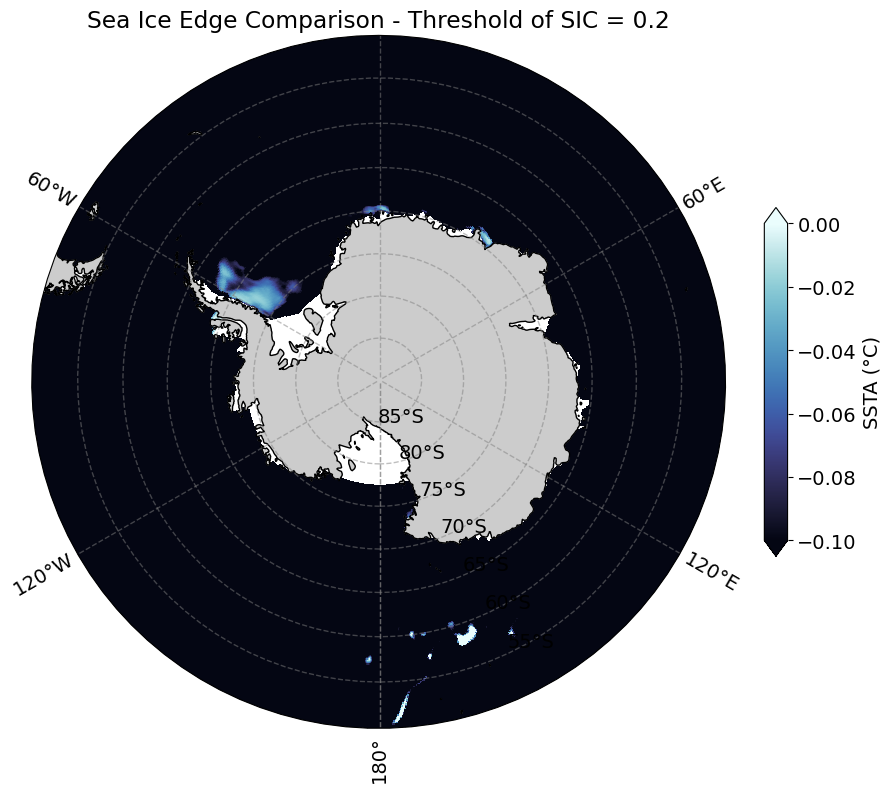

CPU times: user 1min 9s, sys: 9.33 s, total: 1min 18s
Wall time: 1min 9s


In [25]:
%%time
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cft
import cmocean.cm as cm
%matplotlib inline
import matplotlib.path as mpath

# Define contour levels
levels = [0.2]

# Set projection and figure
projection = ccrs.SouthPolarStereo()
fig, ax = plt.subplots(figsize=(10, 9), subplot_kw={'projection': projection})

# Set extent and add features
ax.set_extent([-280, 80, -80, -50], crs=ccrs.PlateCarree())
land_50m = cft.NaturalEarthFeature("physical", "land", "50m", edgecolor="black", facecolor="papayawhip", linewidth=0.5)
ax.add_feature(land_50m, color=[0.8, 0.8,
                                0.8])
ax.coastlines(resolution="50m")

# Add circular boundary for the polar projection
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

evap_sample = evap.sel(time = '2023-01-10', method='nearest')*24*3600
evap_sample.plot(
    x="xt_ocean",
    y="yt_ocean",
    transform=ccrs.PlateCarree(),
    vmin=-0.1,
    vmax=.0,
    cmap=cm.ice,
    extend="both",
    cbar_kwargs={"label": "SSTA (°C)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
    ax=ax
)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.ylines = True

plt.title('Sea Ice Edge Comparison - Threshold of SIC = 0.2')
plt.show()

## Curl

In [9]:
dxt = cc.querying.getvar(expt='025deg_jra55_iaf_cycle6_online_mlt', variable='dxt', 
                           session=session,
                           chunks={'time':-1,'xu_ocean':'300MB','yu_ocean':'300MB'}).\
                            sel(time = slice('1982','2023'))

dyt = cc.querying.getvar(expt='025deg_jra55_iaf_cycle6_online_mlt', variable='dyt', 
                           session=session, 
                           chunks={'time':-1,'xu_ocean':'300MB','yu_ocean':'300MB'}).\
                            sel(time = slice('1982','2023'))

dxu = cc.querying.getvar(expt='025deg_jra55_iaf_cycle6_online_mlt', variable='dxu', 
                           session=session,
                           chunks={'time':-1,'xu_ocean':'300MB','yu_ocean':'300MB'}).\
                            sel(time = slice('1982','2023'))

dyu = cc.querying.getvar(expt='025deg_jra55_iaf_cycle6_online_mlt', variable='dyu', 
                           session=session,
                           chunks={'time':-1,'xu_ocean':'300MB','yu_ocean':'300MB'}).\
                            sel(time = slice('1982','2023'))


2025-09-14 19:44:34,176 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-24.12/lib/python3.11/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-24.12/lib/python3.11/site-packages/distributed/worker.py", line 1269, in heartbeat
    response = await retry_operation(
               ^^^^^^^^^^^^^^^^^^^^^^
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-24.12/lib/python3.11/site-packages/distributed/utils_comm.py", line 441, in retry_operation
    return await retry(
           ^^^^^^^^^^^^
  File "/g/d

KeyboardInterrupt: 

ker.finished()
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-24.12/lib/python3.11/site-packages/distributed/core.py", line 494, in finished
    await self._event_finished.wait()
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-24.12/lib/python3.11/asyncio/locks.py", line 213, in wait
    await fut
asyncio.exceptions.CancelledError
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-24.12/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-24.12/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-24.12/lib/python3.11/site-packages/distributed/process.py", line 202, in _run
    target(*args, **kwargs)
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-24.12/lib/python3.11/site-packages/distributed/nanny.py", line 1023, in _run
    asyncio_run(run(), loop_f

In [7]:
import xarray as xr
import xgcm
import numpy as np
import matplotlib.pyplot as plt

# ----------------------
# Assume tau_x and tau_y are DataArrays with coords xu_ocean and yu_ocean
# ----------------------
ds = xr.Dataset({"tau_x": tau_x, "tau_y": tau_y})

# --- Setup xgcm grid using the existing coordinates
ds.coords["xu_ocean"].attrs.update(axis="X")
ds.coords["yu_ocean"].attrs.update(axis="Y")

grid = xgcm.Grid(ds, periodic=["X"])

# --- Pick a single time index
t0 = 0
ds_t = ds.isel(time=t0)

# --- Compute wind stress curl (grid units)
d_tauy_dx = grid.diff(ds_t["tau_y"], "X", boundary="extend")
d_taux_dy = grid.diff(ds_t["tau_x"], "Y", boundary="extend")
curl_tau = d_tauy_dx - d_taux_dy
curl_tau = curl_tau.rename("wind_stress_curl")
curl_tau.attrs["long_name"] = "Wind stress curl (grid units)"
curl_tau.attrs["units"] = "N m^-2 per grid cell"

# --- Subset for lon/lat box: -190 to -180 (xu_ocean), -72 to -69 (yu_ocean)
lon_mask = (ds_t["xu_ocean"] >= -190) & (ds_t["xu_ocean"] <= -180)
lat_mask = (ds_t["yu_ocean"] >= -72) & (ds_t["yu_ocean"] <= -69)
curl_subset = curl_tau.sel(xu_ocean=lon_mask, yu_ocean=lat_mask)

# --- Average over the selected box
curl_mean = curl_subset.mean(dim=["xu_ocean", "yu_ocean"]).item()
print(f"Mean wind stress curl in the selected box: {curl_mean:.3e} (grid units)")

# --- Plot the subset
plt.figure(figsize=(6,4))
plt.contourf(ds_t["xu_ocean"].values[lon_mask], ds_t["yu_ocean"].values[lat_mask],
             curl_subset, levels=21, cmap="RdBu_r", extend="both")
plt.colorbar(label="Wind stress curl (grid units)")
plt.title("Wind stress curl in selected region")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()



KeyError: 'center'